In [12]:


import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import defaultdict

# ============= PARAMETERS TO TUNE =============
# Visualization
LINE_COLOR = (0, 255, 0)      # Green color for detected lines (BGR)
LINE_THICKNESS = 2            # Line thickness in pixels
EDGE_COLOR = (255, 255, 255)  # White color for edge
# ============================================

# Canny edge detection
CANNY_LOW_THRESHOLD = 50       # Lower = more edge pixels detected
CANNY_HIGH_THRESHOLD = 150     # Higher = only strong edges kept

# Preprocessing
BLUR_KERNEL_SIZE = 3         # Gaussian blur kernel size (must be odd)

# Hough Line Detection
HOUGH_RHO = 1                 # Distance resolution in pixels
HOUGH_THETA = np.pi / 180     # Angle resolution in radians (1 degree)
HOUGH_THRESHOLD = 10         # Minimum votes to detect a line
HOUGH_MIN_LINE_LENGTH = 50    # Minimum line length (for HoughLinesP)
HOUGH_MAX_LINE_GAP = 10       # Maximum gap between line segments (for HoughLinesP)


MIN_D_THRESH = 10 #This needs to be dynamic based on image size... we need to use hints to guess fretboard distance?



#ToDo find all candidate lines (e.g. large enough set)







In [13]:
def show_cv2_image(image, figsize=(12, 10)):
    plt.figure(figsize=figsize)  # Add this line
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

def get_canny_edges(frame):
    """
    Extract Canny edge detection from frame.

    Args:
        frame: Input BGR image

    Returns:
        edges: Binary edge image
        edges_bgr: BGR version for visualization
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (BLUR_KERNEL_SIZE, BLUR_KERNEL_SIZE), 0)

    # Canny edge detection
    edges = cv2.Canny(blurred, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)

    # Convert edges to BGR for visualization
    edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    return edges, edges_bgr

def detect_hough_lines(edges):
    """
    Detect lines using standard Hough transform.

    Args:
        edges: Binary edge image from Canny

    Returns:
        lines: Array of lines in (rho, theta) format, or None if no lines detected
    """
    # HoughLines returns lines in (rho, theta) format
    # rho: distance from origin to the line
    # theta: angle of the line in radians
    lines = cv2.HoughLinesP(edges,HOUGH_RHO,HOUGH_THETA, HOUGH_THRESHOLD, minLineLength=HOUGH_MIN_LINE_LENGTH, maxLineGap=HOUGH_MAX_LINE_GAP)

    return lines


def filter_lines_by_angle(lines, min_angle, max_angle):
    """
    Filter lines based on their angle from the x-axis (direction ignored).

    Args:
        lines: Array of lines in (x1, y1, x2, y2) format from HoughLinesP
        min_angle: Minimum angle in radians (0 to π/2)
        max_angle: Maximum angle in radians (0 to π/2)

    Returns:
        filtered_lines: Array of lines within the specified angle range, or None if no lines pass

    Note:
        - Angle is measured from the positive x-axis (0 = horizontal, π/2 = vertical)
        - Direction is ignored: both directions of a line are treated as the same angle
        - Use 0 to π/2 radian range regardless of line direction
    """
    if lines is None:
        return None

    filtered = []

    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Calculate angle from x-axis using arctan2
        # arctan2(dy, dx) gives angle in radians from -π to π
        angle = np.arctan2(y2 - y1, x2 - x1)

        # Normalize to 0 to π/2 range (ignore direction)
        angle = np.abs(angle)
        if angle > np.pi / 2:
            angle = np.pi - angle

        # Check if angle is within range
        if min_angle <= angle <= max_angle:
            filtered.append(line)

    if len(filtered) == 0:
        return None

    return np.array(filtered)


def draw_hough_lines(image, lines):
    """
    Draw all detected Hough lines on the image.

    Args:
        image: BGR image to draw on
        lines: Array of lines in (x1, y1, x2, y2) format from HoughLinesP

    Returns:
        output: Image with lines drawn
    """
    output = image.copy()

    if lines is None:
        return output

    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Calculate angle for color coding
        angle_rad = np.arctan2(y2 - y1, x2 - x1)
        cos_theta = np.cos(angle_rad)
        sin_theta = np.sin(angle_rad)

        # Color code based on angle
        origin = [120, 255/2, 255/2]
        line_colour = tuple([int(origin[0]), int(origin[1] + float(cos_theta*255/2)), int(origin[2] + sin_theta*255/2)])

        # Draw the line segment
        cv2.line(output, (x1, y1), (x2, y2), line_colour, LINE_THICKNESS)

    return output

class Vec2d:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class LineSegment:
    def __init__(self, x1, y1, x2, y2):
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2

        self.angle = np.arctan2(y2 - y1, x2 - x1)
        
        # Calculate m and c (handle vertical lines)
        if x2 - x1 != 0:
            self.m = (y2 - y1) / (x2 - x1)
            self.c = y1 - self.m * x1
            self.is_vertical = False
        else:
            self.m = float('inf')
            self.c = x1  # Store x value for vertical lines
            self.is_vertical = True
    
    def intersection(self, other):
        """Find intersection point of the infinite lines"""
        if self.is_vertical and other.is_vertical:
            return None  # Parallel vertical lines
        if self.is_vertical:
            x = self.c
            y = other.m * x + other.c
            return Vec2d(x, y)
        if other.is_vertical:
            x = other.c
            y = self.m * x + self.c
            return Vec2d(x, y)
        if self.m == other.m:
            return None  # Parallel lines
        
        x = (other.c - self.c) / (self.m - other.m)
        y = self.m * x + self.c
        return Vec2d(x, y)
    
    def point_on_segment(self, x, y):
        """Check if point (x,y) lies within the segment bounds"""
        min_x, max_x = min(self.x1, self.x2), max(self.x1, self.x2)
        min_y, max_y = min(self.y1, self.y2), max(self.y1, self.y2)
        return min_x <= x <= max_x and min_y <= y <= max_y
    
    def point_distance(self, pos):
        """Perpendicular distance from point to infinite line"""
        if self.is_vertical:
            return abs(pos.x - self.c)
        return abs(self.m * pos.x - pos.y + self.c) / np.sqrt(self.m**2 + 1)
    
    def closest_point_on_segment(self, pos):
        """Find closest point on segment to given point"""
        dx, dy = self.x2 - self.x1, self.y2 - self.y1
        length_sq = dx**2 + dy**2
        
        if length_sq == 0:
            return Vec2d(self.x1, self.y1)
        
        t = max(0, min(1, ((pos.x - self.x1) * dx + (pos.y - self.y1) * dy) / length_sq))
        return Vec2d(self.x1 + t * dx, self.y1 + t * dy)

def point_to_point_dist(p1, p2):
    return np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

def min_distance(l1, l2):
    """Minimum distance between two line segments"""
    # Check if segments intersect
    intersection = l1.intersection(l2)
    if intersection and l1.point_on_segment(intersection.x, intersection.y) and l2.point_on_segment(intersection.x, intersection.y):
        return 0.0
    
    # Check distances from each endpoint to the other segment
    p1 = Vec2d(l1.x1, l1.y1)
    p2 = Vec2d(l1.x2, l1.y2)
    p3 = Vec2d(l2.x1, l2.y1)
    p4 = Vec2d(l2.x2, l2.y2)
    
    distances = [
        point_to_point_dist(p1, l2.closest_point_on_segment(p1)),
        point_to_point_dist(p2, l2.closest_point_on_segment(p2)),
        point_to_point_dist(p3, l1.closest_point_on_segment(p3)),
        point_to_point_dist(p4, l1.closest_point_on_segment(p4)),
    ]
    
    return min(distances)

def group_lines(vertical_lines):
    line_objs = []

    index_to_neigbours_mapping = defaultdict(set)

    for line in vertical_lines:
        x1, y1, x2, y2 = line[0]
        line_objs.append(LineSegment(x1,y1,x2,y2))


    buckets = []

    def get_bucket_index(buckets, index):
        for bucket_index in range(len(buckets)):
            if index in buckets[bucket_index]:
                return bucket_index
        return -1


    for line1_index in range(len(line_objs)):
        line1 = line_objs[line1_index]

        bucket_index = get_bucket_index(buckets, line1_index)
        if get_bucket_index(buckets,line1_index) == -1:
            buckets.append({line1_index})

        for line2_index in range(line1_index+1, len(line_objs)):
            line2 = line_objs[line2_index]
            min_d = min_distance(line1,line2)
            if min_d < MIN_D_THRESH:
                buckets[bucket_index].add(line2_index)
    

    np_lines_buckets = []
    for bucket in buckets:
        np_lines = []
        for line_index in bucket:
            np_lines.append(vertical_lines[line_index])
        
        np_lines_buckets.append(np_lines)

    return np_lines_buckets

def merge_lines_in_bucket(buckets):
    lines_to_draw = []
    for bucket in buckets:
        line =bucket[0]
        lines_to_draw.append(line)
    return lines_to_draw


In [14]:
def show_found_fret_lines(image_path):
    image = cv2.imread(image_path)
    edges, edges_bgr = get_canny_edges(image)
    lines = detect_hough_lines(edges)
    vertical_lines = filter_lines_by_angle(lines, min_angle=np.pi/2 - np.pi/8, max_angle=np.pi/2 + np.pi/8)
    horizontal_lines = filter_lines_by_angle(lines, min_angle=-np.pi/8, max_angle=np.pi/8)
    grouped_vertical_lines = group_lines(vertical_lines)
    merged_grouped_vertical_lines = merge_lines_in_bucket(grouped_vertical_lines)
    with_vertical_lines = draw_hough_lines(edges_bgr, merged_grouped_vertical_lines)
    with_all_lines = draw_hough_lines(with_vertical_lines, horizontal_lines)
    show_cv2_image(with_all_lines, figsize=(24, 20))


Processing: images/perspective2.png


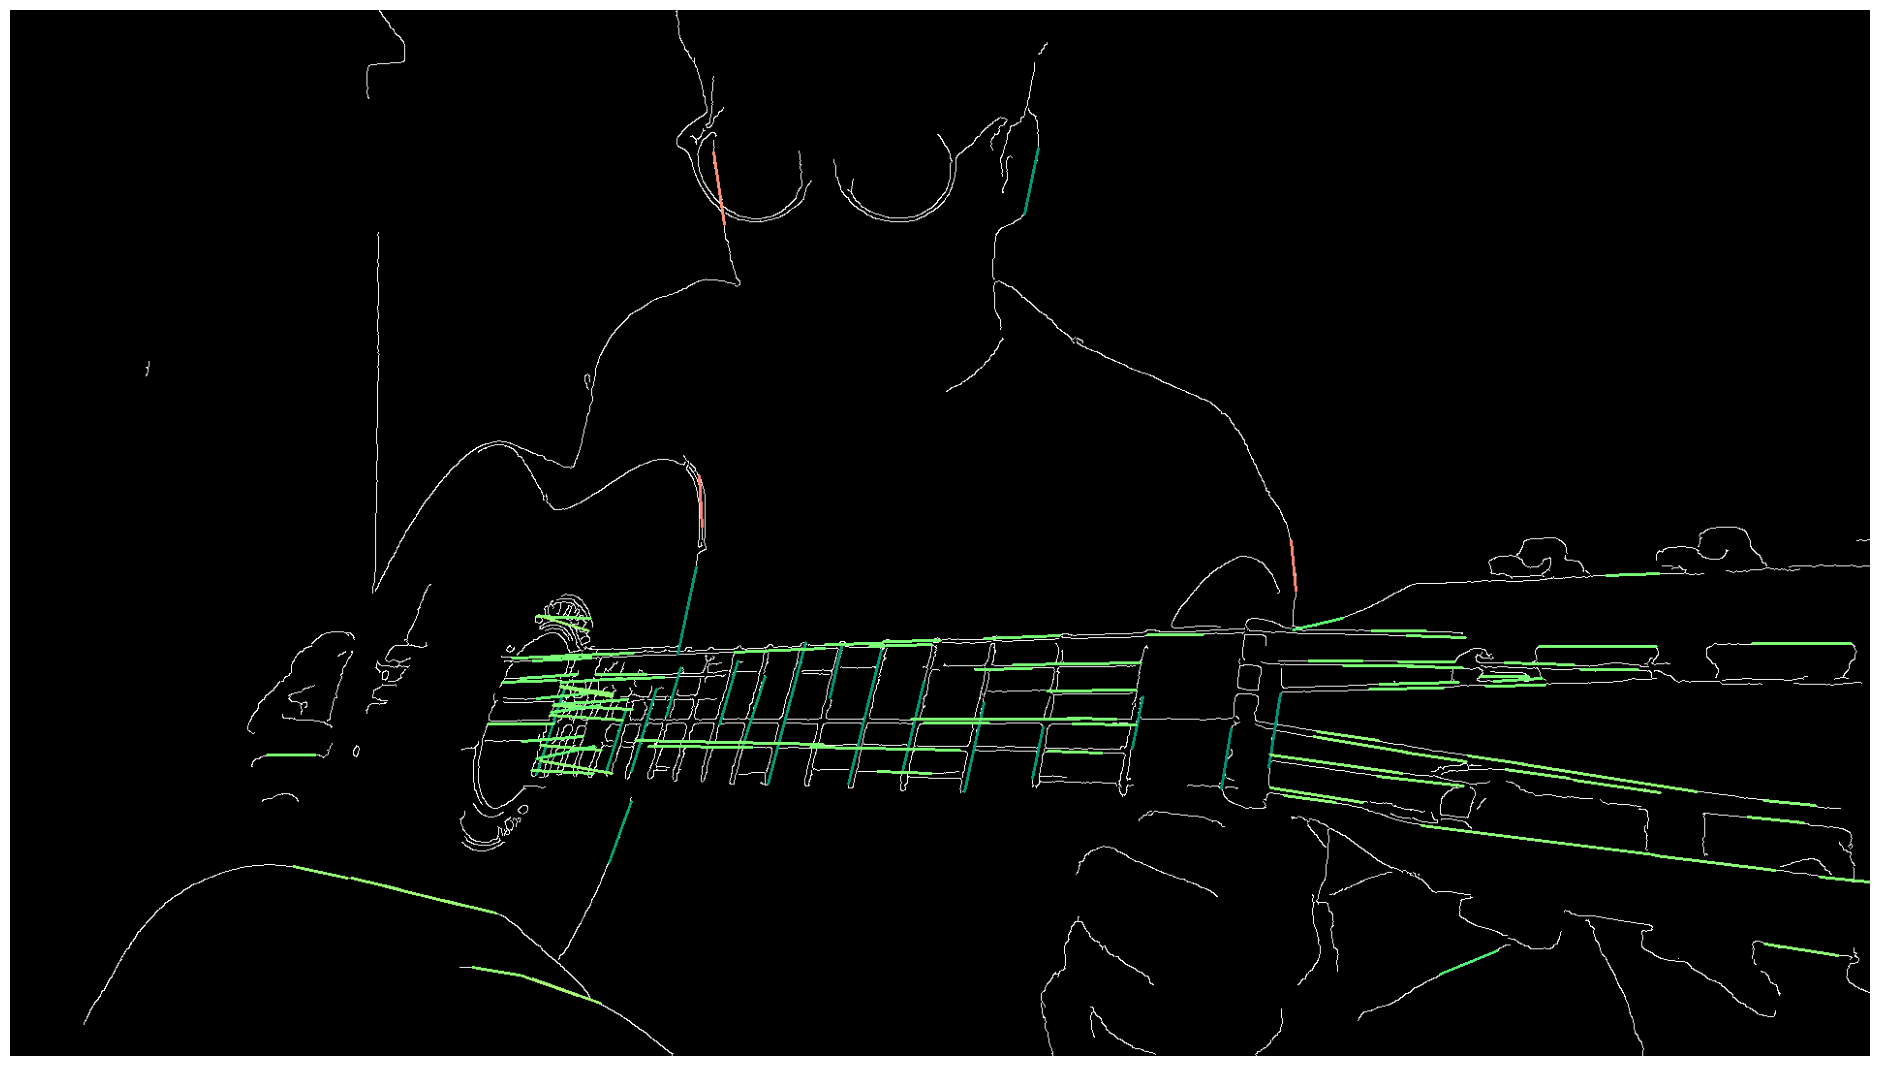

Processing: images/flat-distance.png


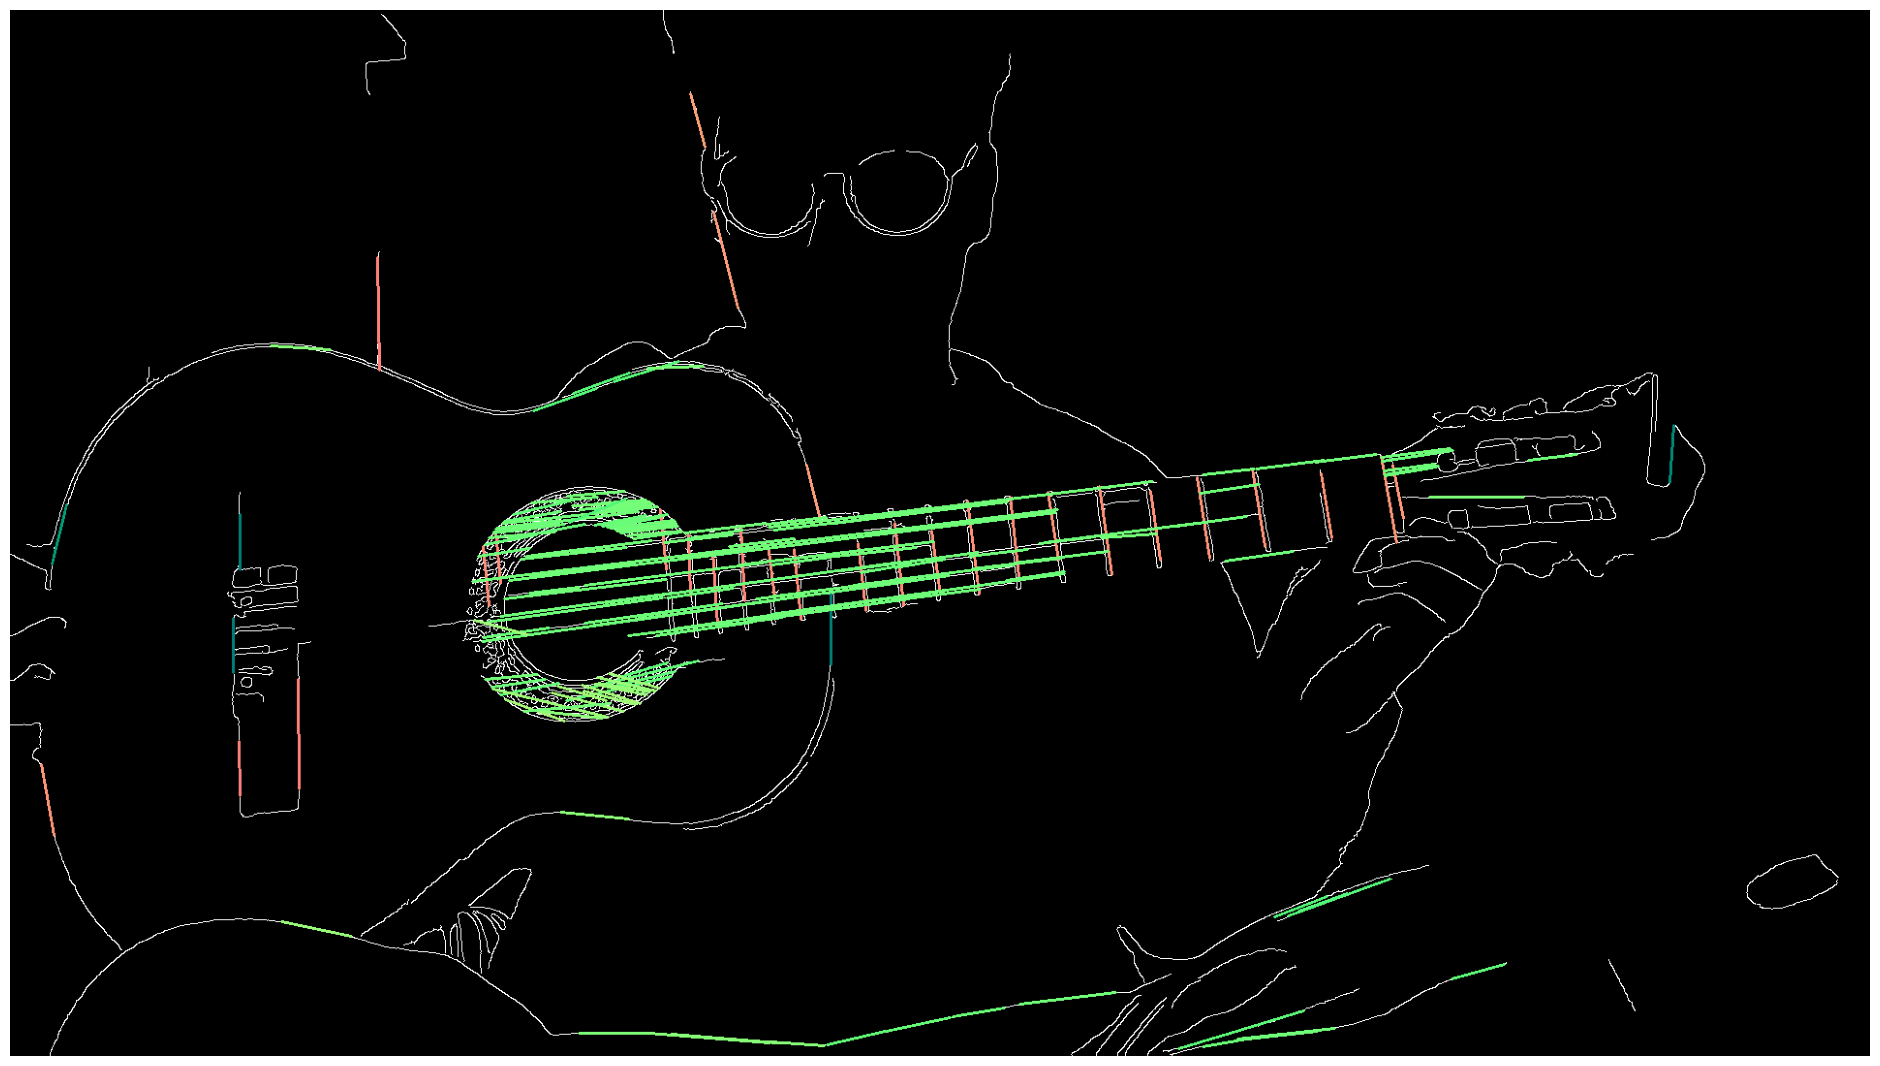

Processing: images/oclusion.png


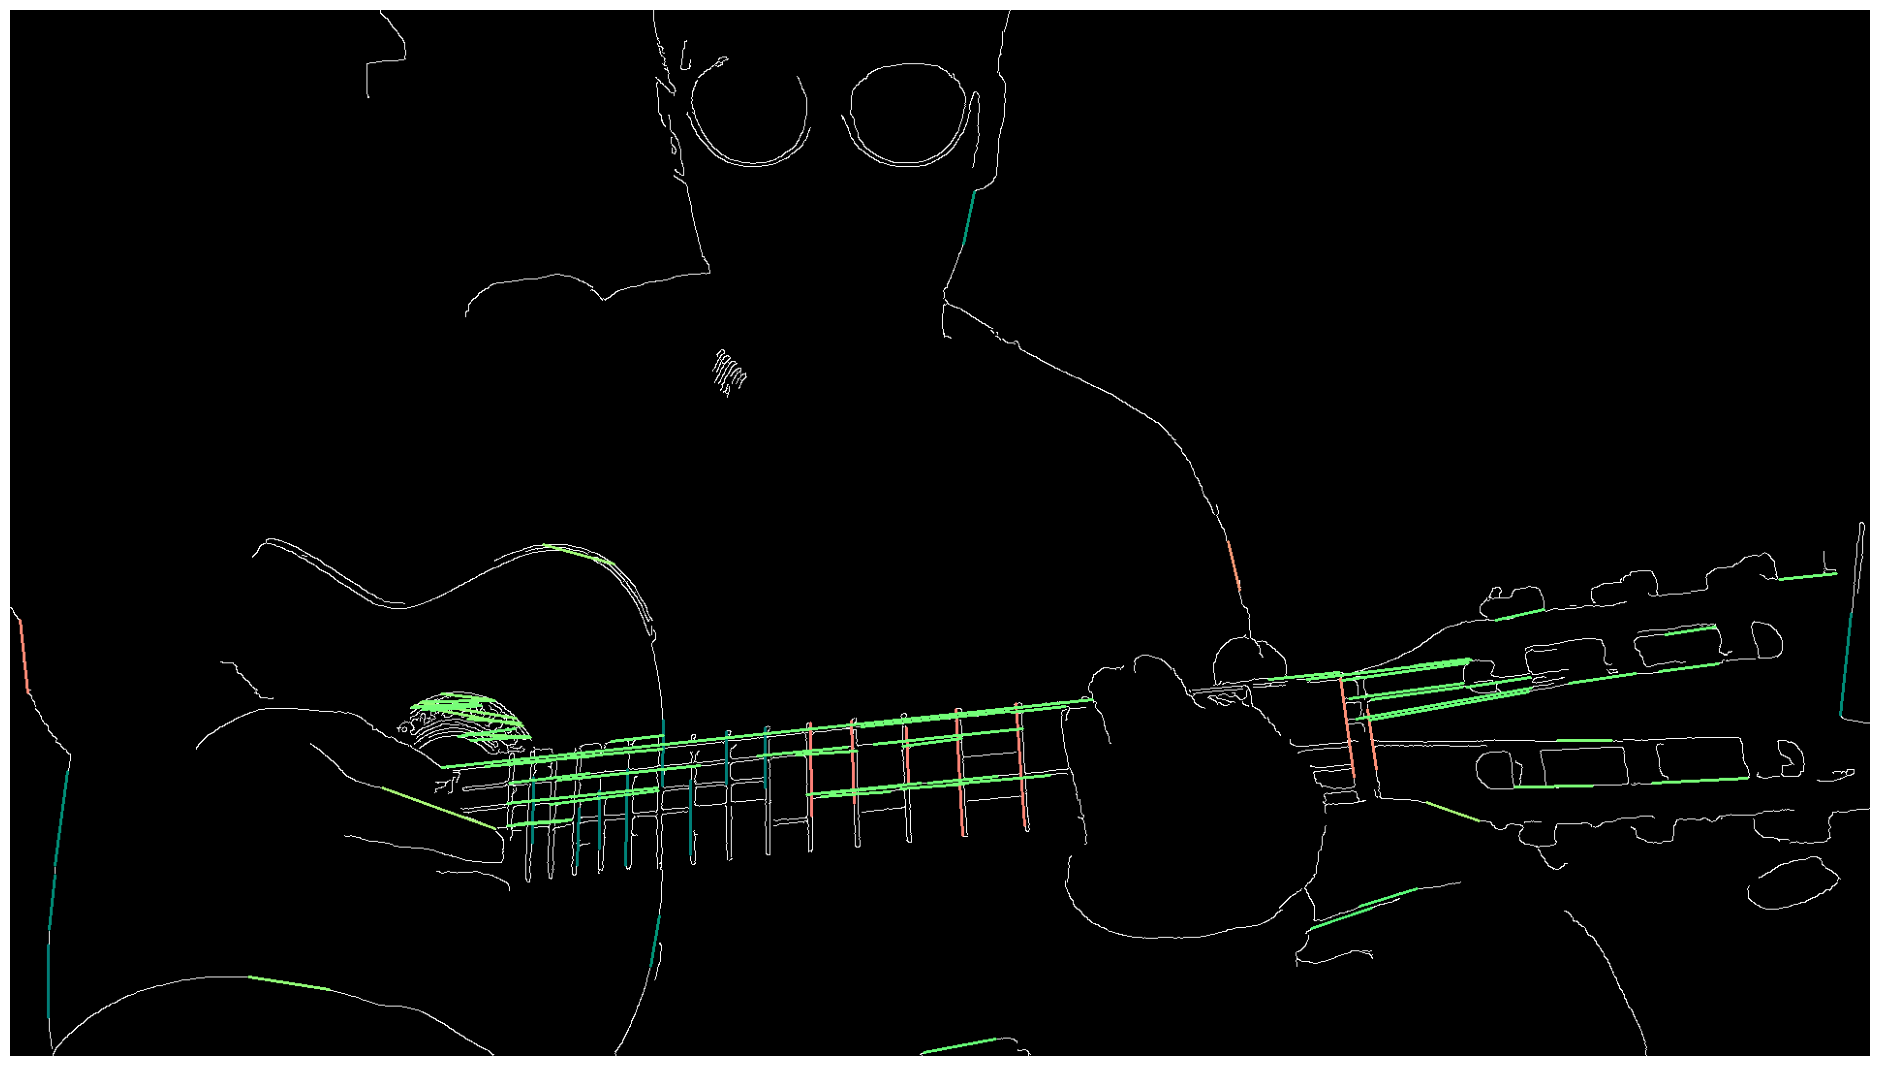

Processing: images/perspective.png


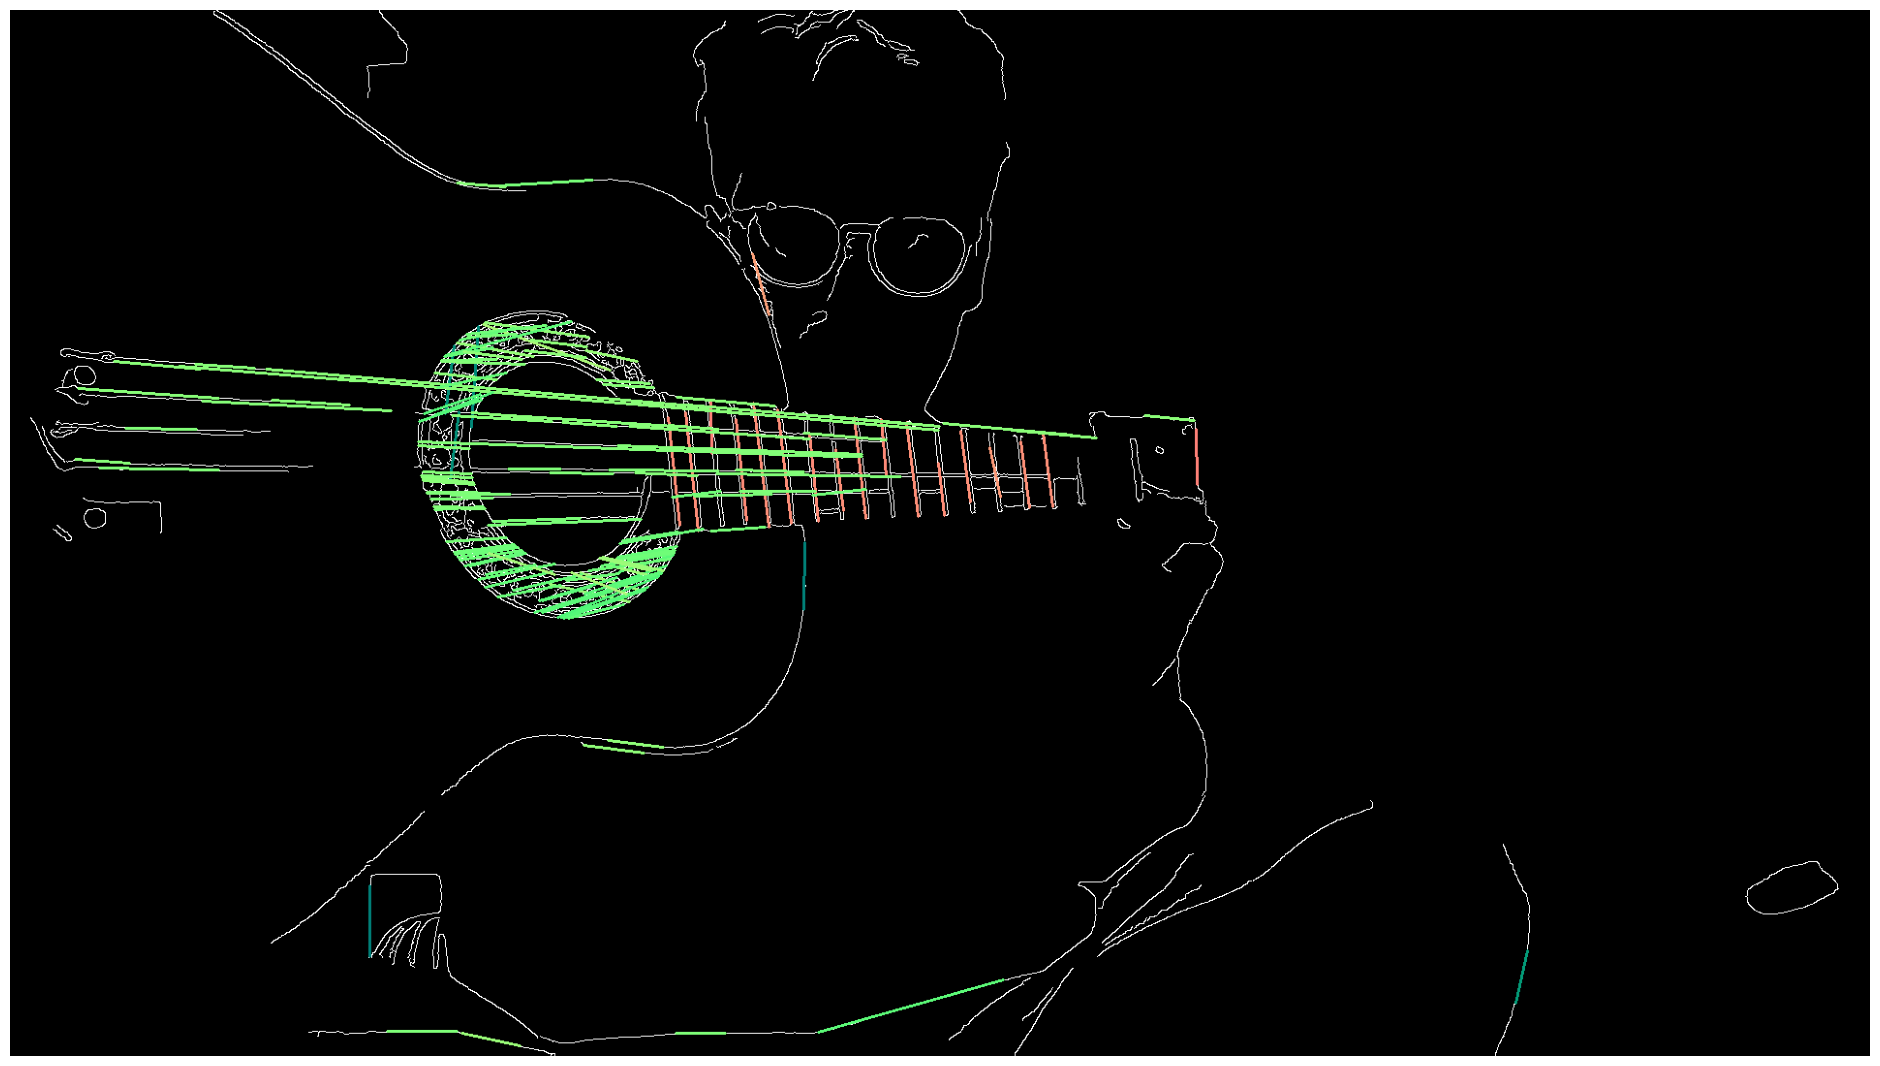

In [15]:
import glob

for image_path in glob.glob('images/*.[pj][np][g]*'):
    print(f"Processing: {image_path}")
    show_found_fret_lines(image_path)